Hello

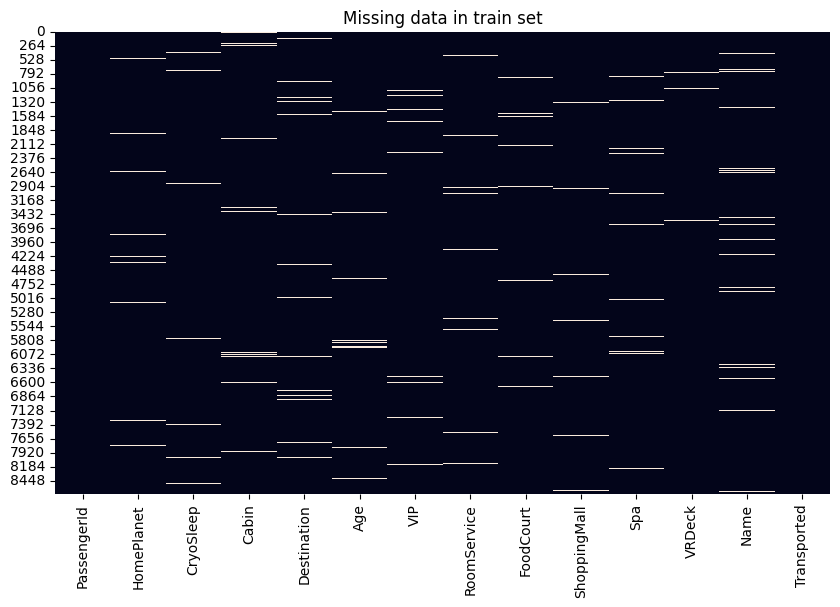

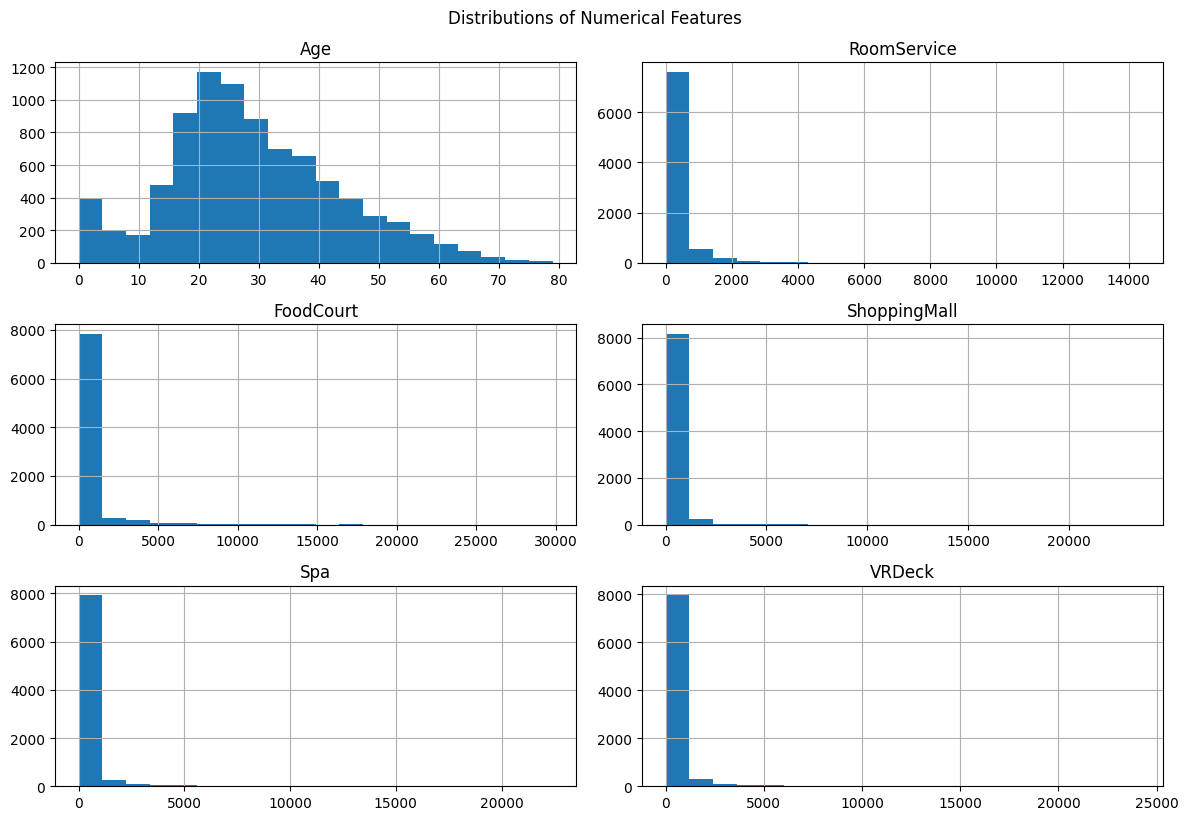

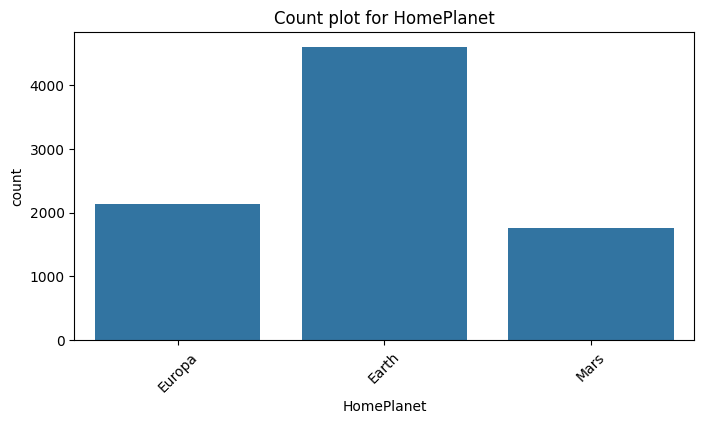

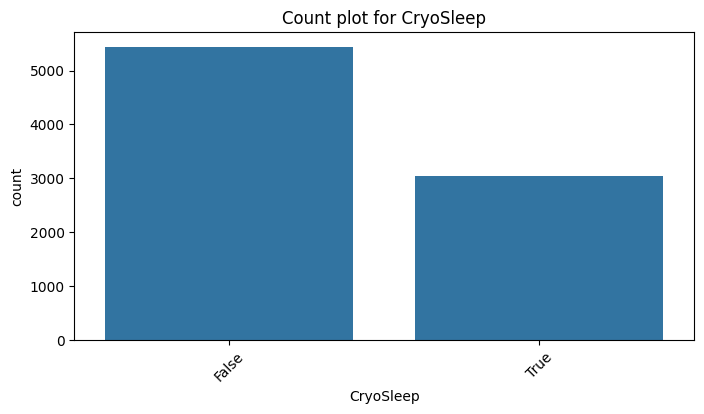

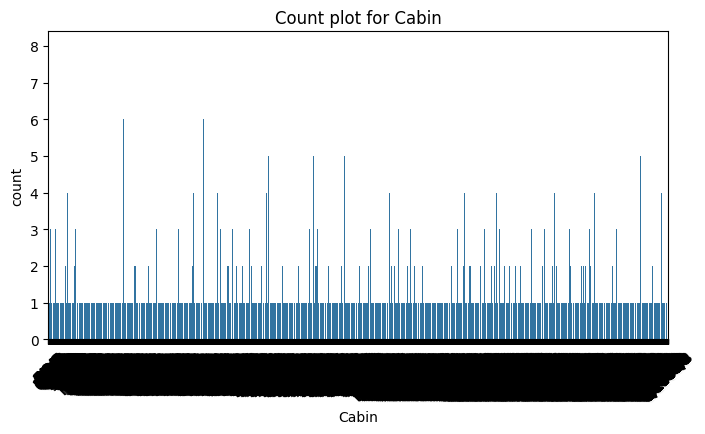

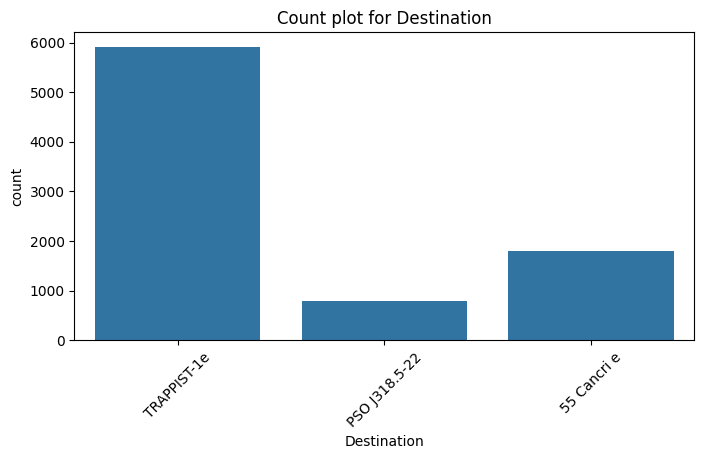

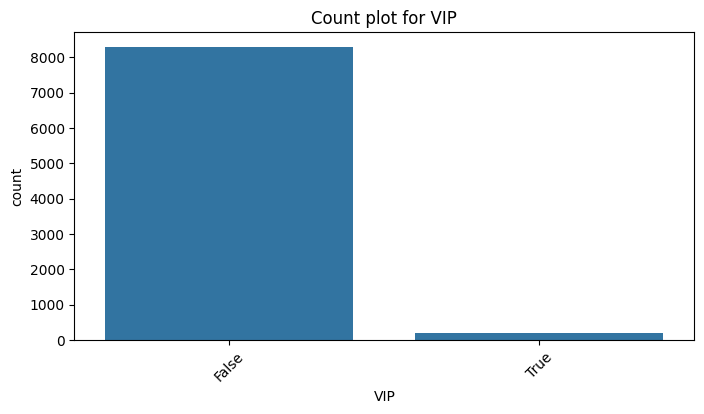

Validation Accuracy: 0.7745830937320299
Submission file saved as submission.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# -------------------------------
# 1. Load Data
# -------------------------------
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# -------------------------------
# 2. Visualize missing data and distributions
# -------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False)
plt.title("Missing data in train set")
plt.show()

numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train_df[numerical_features].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.suptitle("Distributions of Numerical Features", y=1.02)
plt.show()

categorical_features = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']
for col in categorical_features:
    if col in train_df.columns:
        plt.figure(figsize=(8,4))
        sns.countplot(data=train_df, x=col)
        plt.title(f"Count plot for {col}")
        plt.xticks(rotation=45)
        plt.show()

# -------------------------------
# 3. Prepare data for pipeline
# -------------------------------
# Keep PassengerId for submissions
train_ids = train_df["PassengerId"]
test_ids = test_df["PassengerId"]

# Convert target values to binary
train_df["Transported"] = train_df["Transported"].astype(str).map({'True': 1, 'False': 0})
y = train_df["Transported"]

# Drop columns not used for training
# Drop target, PassengerId, Name from training features.
train_df = train_df.drop(["Transported", "PassengerId", "Name"], axis=1, errors='ignore')
test_df = test_df.drop(["PassengerId", "Name"], axis=1, errors='ignore')

# -------------------------------
# 4. Build preprocessing pipeline
# -------------------------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# We'll apply the transformers on the defined columns.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# -------------------------------
# 5. Build full pipeline and train model
# -------------------------------
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Split data for local validation
X_train, X_val, y_train, y_val = train_test_split(train_df, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
y_val_pred = clf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

# -------------------------------
# 6. Predict outcome for test set and export submission file
# -------------------------------
test_preds = clf.predict(test_df)
test_preds_bool = np.where(test_preds==1, True, False)

submission = pd.DataFrame({
    "PassengerId": test_ids,
    "Transported": test_preds_bool
})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")